# Исправление временного сдвига для событий 2013г 

In [1]:
!date
!pwd
!ls ./data

Ср май 30 12:21:05 MSK 2018
/home/sphere/github/Sphere/Data2013
10675.txt	11362.txt	11588.work.txt	      flight2.dbg.dat
10675.txt.old	11368.txt	11589.frame	      flight3.dbg.2013.dat
10675.work.csv	11418.txt	11589.work.csv	      flight3.dbg.dat
10675.work.txt	11452.frame	11589.work.txt	      flight4.dbg.2013.dat
11284.txt	11452.toff	12114.frame	      flight4.dbg.dat
11286.txt	11452.txt	12114.toff	      flight5.dbg.2013.dat
11286.work.csv	11452.work.csv	12114.txt	      flight5.dbg.dat
11302.txt	11468.txt	12114.work.csv	      height_2013.csv
11302.work.csv	11468.work.csv	cal		      minus_pied_csv
11308.frame	11588.dat	datum_2013.csv	      shifted_csv
11308.toff	11588.frame	exotic		      shifted_fig
11308.txt	11588.toff	flight1.dbg.2013.dat
11308.work.csv	11588.txt	flight1.dbg.dat
11358.txt	11588.work.csv	flight2.dbg.2013.dat


In [2]:
####%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import copy

In [3]:
plt.rcParams['figure.figsize'] =(12,6)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

In [23]:
def read_file(filename):
    # считать данные, заменив 0 на NaN
    datum = []
    na_values = ['NO CLUE', 'N/A', '0']
    try:
        datum = pd.read_csv(filename, na_values=na_values, header = None, index_col=False, sep=',')
    except:
        return datum, 1

    # убрать последние три канала
    param = [i for i in range(109)]
    datum = datum[param]

    # отрицательные значения заменить на маленькое положительное 0.001
    # маленькие значения (< minshow) заменить на маленькое положительное minpos = 0.0001
    minshow = 0.01
    minpos = 0.0001
    for i in range(datum.shape[1]):
        zero_cell = datum[i] <= minshow
        datum.loc[zero_cell, i] = minpos
    datum.fillna(0.001, inplace = True)
    #datum.shape   
    return datum, 0

In [5]:
def draw_one_frame(datum, ax, i, title):
    colorscale = "gist_yarg"
    cbar = True
    xt, yt = 0, 1
    xb, yb = 108.1, 969
    sns.heatmap(np.log(datum), ax=ax, cmap = colorscale,
                cbar=i == 0,
                vmin=0, 
                xticklabels=20, yticklabels=200,
               )
    ax.plot(( xt, xt),( yt, yb),'k')
    ax.plot(( xt, xb),( yb, yb),'k')
    ax.plot(( xb, xb),( yb, yt),'k')
    ax.plot(( xt, xb),( yt, yt),'k')
    #ax.axhline(y=427,linewidth=1, color='r') 
    ax.set_title(title)
    ax.set_xlabel('N, PMT number')
    if i == 0:
        ax.set_ylabel('T, Time bin number')

In [6]:
### caclulate the drift
def shift_calc(frame):
    tmin, tmax = 850, 930 
    #if fr == 1:
        #tmin, tmax = 400,487
    cumsum1 = frame[tmin:tmax].cumsum()
    half = cumsum1[:][len(cumsum1)-1:len(cumsum1)]/2
    idx = []
    for i in range(109):
        idx.append(cumsum1[i][cumsum1[i] > float(half[i])].index.min())
    idx = pd.DataFrame(idx)
    shi = idx - int(idx.mean())
    return list(shi[0])


### apply drift to data
def shift_make(frame, shift):
    dim = frame.shape[0]
    minpos = 0.00001
    oldframe = copy.deepcopy(frame)
    newframe = copy.deepcopy(frame)
    for chan in range(109):
        drift = shift[chan]
        if drift > 0:
            for i in range(dim - drift):
                #if fr == 1 and chan == 78 : print('chan=',chan, drift, i, i + drift)
                newframe.loc[i, chan] = oldframe[chan][i + drift]
            for i in range(dim - drift, dim):
                newframe.loc[i, chan] = minpos
        if drift < 0:
            drift *= -1
            for i in range(dim-1, drift-1, -1):
                newframe.loc[i, chan] = oldframe[chan][i - drift]
            for i in range(0,drift):
                newframe.loc[i, chan] = minpos
    return newframe

## Read data

In [42]:
# read one frame
num = 10675
title = str(num)
name = 'data/minus_pied_csv/' + str(num) + '.csv'
frame, error =  read_file(name)
print('file %s read with error %d' % (name, error) )

file data/minus_pied_csv/10675.csv read with error 0


### Frames before calibration and time drift corrections

In [ ]:
fig, axn = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,12))
draw_one_frame(frame,axn,0,title)

### Time Drift correction

In [16]:
### считаем сдвиг в каналах ###
shift=shift_calc(frame)
print(shift)

[1, 1, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 4, 0, 1, 4, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -3, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [17]:
### производим сдвиг в каналах ###
nframe = shift_make(frame, shift)

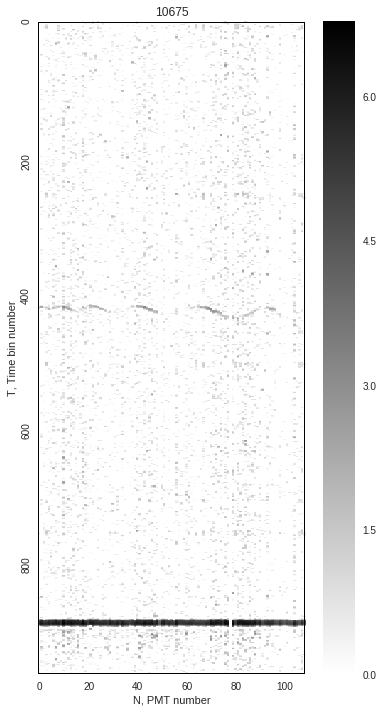

In [21]:
fig, axn = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,12))
draw_one_frame(nframe,axn,0,title)
#fig.
namefig = 'data/shifted_fig/' + str(num) + '.png'
plt.savefig(namefig, bbox_inches='tight')

In [22]:
# save shifted frame data to file
nameout = 'data/shifted_csv/shifted' + str(num) + '.csv'
nframe[0].to_csv(nameout)

# много файлов

In [10]:
plt.close("all")

In [28]:
#for num in range(10746, 11000):
for num in range(11000, 14490):
#for num in range(10000, 10020):

    title = str(num)
    name    = 'data/minus_pied_csv/' + str(num) + '.csv'
    namefig = 'data/shifted_fig/'    + str(num) + '.png'
    nameout = 'data/shifted_csv/shifted' + str(num) + '.csv'
 
    # read
    frame,error = read_file(name)
    if error == 1:
        print('file %s not found' % name )
        continue
    else:
        print(num, end = ' ')
        
    # shift
    shift=shift_calc(frame)
    nframe = shift_make(frame, shift)
    
    # draw
    fig, axn = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,12))
    draw_one_frame(nframe,axn,0,title)
    plt.savefig(namefig, bbox_inches='tight')
    plt.close(fig)
    
    #save
    nframe.to_csv(nameout)   

11000 11001 11002 11003 11004 11005 11006 11007 11008 11009 11010 11011 11012 11013 11014 11015 11016 11017 11018 11019 11020 11021 11022 11023 11024 11025 11026 11027 11028 11029 11030 11031 11032 11033 11034 11035 11036 11037 11038 11039 11040 11041 11042 11043 11044 11045 11046 11047 11048 11049 11050 11051 11052 11053 11054 11055 11056 11057 11058 11059 11060 11061 11062 11063 11064 11065 11066 11067 11068 11069 11070 11071 11072 11073 11074 11075 11076 11077 11078 11079 11080 11081 11082 11083 11084 11085 11086 11087 11088 11089 11090 11091 11092 11093 11094 11095 11096 11097 11098 11099 11100 11101 11102 11103 11104 11105 11106 11107 11108 11109 11110 11111 11112 11113 11114 11115 11116 11117 11118 11119 11120 11121 11122 11123 11124 11125 11126 11127 11128 11129 11130 11131 11132 11133 11134 11135 11136 11137 11138 11139 11140 11141 11142 11143 11144 11145 11146 11147 11148 11149 11150 11151 11152 11153 11154 11155 11156 11157 11158 11159 11160 11161 11162 11163 11164 11165 1116